In [1]:
#2.1

In [2]:
import tensorflow_datasets as tfds
[test_set_raw, valid_set_raw, train_set_raw], info = tfds.load(
    "tf_flowers",
split=["train[:10%]", "train[10%:25%]", "train[25%:]"], as_supervised=True,
with_info=True)

/opt/homebrew/Caskroom/miniforge/base/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-06-09 13:35:23.063819: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 100%|█████████████████████████| 5/5 [00:03<00:00,  1.54 file/s]

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Metal device set to: Apple M1



2022-06-09 13:35:28.072632: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-09 13:35:28.072741: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='~/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [4]:
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes
dataset_size = info.splits["train"].num_examples

In [5]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [6]:
n_classes

5

In [7]:
dataset_size

3670

Fontconfig warning: ignoring UTF-8: not a valid region tag
2022-06-09 13:35:30.000694: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-09 13:35:30.154561: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


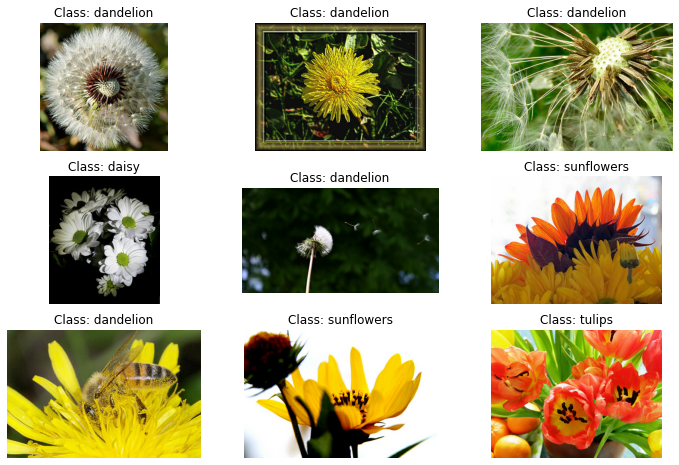

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
index = 0
sample_images = train_set_raw.take(9) 
for image, label in sample_images:
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label])) 
    plt.axis("off")
plt.show(block=False)

In [9]:
#2.2.1

In [10]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224]) 
    return resized_image, label

In [11]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [12]:

batch_size = 32
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1) 
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

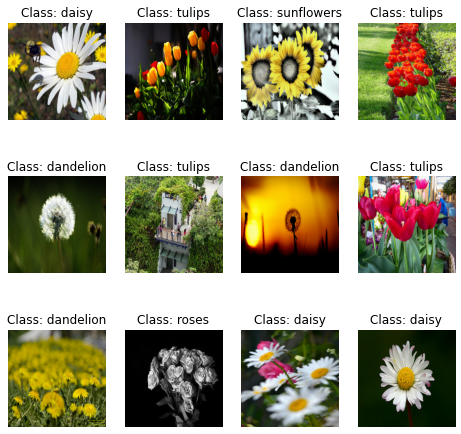

In [13]:
plt.figure(figsize=(8, 8)) 
sample_batch = train_set.take(1)
for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3, 4, index + 1) 
        plt.imshow(X_batch[index]/255.0)
        plt.title("Class: {}".format(class_names[y_batch[index]])) 
        plt.axis("off")
plt.show()

In [14]:
#2.2.2

In [15]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Rescaling(scale=1./127.5, offset=-1))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=7, input_shape=[224, 224, 1],padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2))
model.add(tf.keras.layers.Conv2D(filters=128,kernel_size=5))
model.add(tf.keras.layers.MaxPool2D(pool_size=2))
model.add(tf.keras.layers.Conv2D(filters=256,kernel_size=3))
model.add(tf.keras.layers.MaxPool2D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(25,activation="relu"))
model.add(tf.keras.layers.Dense(128,activation="relu"))
model.add(tf.keras.layers.Dense(64,activation="relu"))
model.add(tf.keras.layers.Dense(10,activation="softmax"))

In [16]:
opt = tf.keras.optimizers.get("sgd")
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

In [17]:
history = model.fit(train_set, epochs=10, validation_data=valid_set)

Epoch 1/10


2022-06-09 13:35:32.536978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - ETA: 0s - loss: 1.5924 - accuracy: 0.3365

2022-06-09 13:36:18.227214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - 49s 533ms/step - loss: 1.5924 - accuracy: 0.3365 - val_loss: 1.4364 - val_accuracy: 0.3684
Epoch 2/10
86/86 [==============================] - 46s 530ms/step - loss: 1.2175 - accuracy: 0.4964 - val_loss: 1.2335 - val_accuracy: 0.4628
Epoch 3/10
86/86 [==============================] - 46s 529ms/step - loss: 1.1004 - accuracy: 0.5570 - val_loss: 1.0541 - val_accuracy: 0.5644
Epoch 4/10
86/86 [==============================] - 46s 530ms/step - loss: 1.0154 - accuracy: 0.5945 - val_loss: 1.1090 - val_accuracy: 0.5390
Epoch 5/10
86/86 [==============================] - 46s 529ms/step - loss: 0.9515 - accuracy: 0.6145 - val_loss: 1.0349 - val_accuracy: 0.5771
Epoch 6/10
86/86 [==============================] - 46s 528ms/step - loss: 0.8867 - accuracy: 0.6548 - val_loss: 1.0036 - val_accuracy: 0.5862
Epoch 7/10
86/86 [==============================] - 46s 529ms/step - loss: 0.8071 - accuracy: 0.6879 - val_loss: 1.1127 - val_accuracy: 0.5517
Epoch 8/10

In [18]:
acc_train = model.evaluate(train_set)[1]
acc_test = model.evaluate(test_set)[1]
acc_valid = model.evaluate(valid_set)[1]
simple_cnn_acc = (acc_train, acc_valid, acc_test)

18/18 [==============================] - 3s 157ms/step - loss: 1.1697 - accuracy: 0.5789


In [19]:
import pickle as pkl
fileObject = open("simple_cnn_acc.pkl",'wb')
pkl.dump(simple_cnn_acc, fileObject)
fileObject.close()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      4736      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 128)     102528    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 256)       2

In [20]:
#2.3 

In [21]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = tf.keras.applications.xception.preprocess_input(resized_image)
    return final_image, label


In [22]:
batch_size = 32
train_set = train_set_raw.map(preprocess).shuffle(dataset_size).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

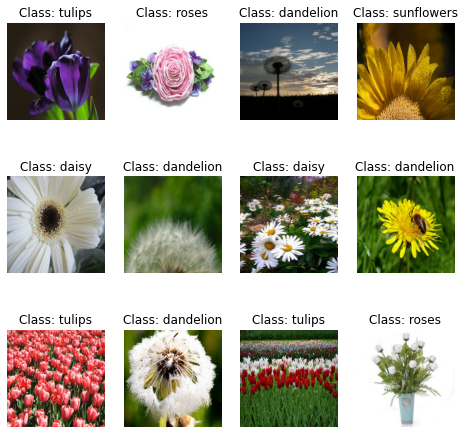

In [23]:
plt.figure(figsize=(8, 8))
sample_batch = train_set.take(1)
for X_batch, y_batch in sample_batch:
    for index in range(12):
        plt.subplot(3, 4, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")
plt.show()

In [24]:
#2.3.2

In [25]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)

83697664/83683744 [==============================] - 1s 0us/step


In [26]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_3
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_4
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_5
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_a

In [27]:
inputs = tf.keras.Input(shape=(3,))
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(10, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [28]:
for layer in base_model.layers:
    layer.trainable = False

In [29]:
opt = tf.keras.optimizers.get("sgd")
model.compile(loss="sparse_categorical_crossentropy",
optimizer=opt, metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5


2022-06-09 13:43:34.677290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - ETA: 0s - loss: 1.0987 - accuracy: 0.6820

2022-06-09 13:44:16.989506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - 51s 567ms/step - loss: 1.0987 - accuracy: 0.6820 - val_loss: 0.7505 - val_accuracy: 0.7641
Epoch 2/5
86/86 [==============================] - 49s 562ms/step - loss: 0.6241 - accuracy: 0.8201 - val_loss: 0.6205 - val_accuracy: 0.7931
Epoch 3/5
86/86 [==============================] - 48s 561ms/step - loss: 0.5238 - accuracy: 0.8405 - val_loss: 0.5603 - val_accuracy: 0.7985
Epoch 4/5
86/86 [==============================] - 48s 561ms/step - loss: 0.4703 - accuracy: 0.8536 - val_loss: 0.5208 - val_accuracy: 0.8131
Epoch 5/5
86/86 [==============================] - 48s 562ms/step - loss: 0.4355 - accuracy: 0.8641 - val_loss: 0.4976 - val_accuracy: 0.8330


In [30]:
for layer in base_model.layers:
    layer.trainable = True

In [31]:
opt = tf.keras.optimizers.get("sgd")
model.compile(loss="sparse_categorical_crossentropy",
optimizer=opt, metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10


2022-06-09 13:47:39.956935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.8103

2022-06-09 13:50:06.807567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - 156s 2s/step - loss: 0.7407 - accuracy: 0.8103 - val_loss: 0.4314 - val_accuracy: 0.8439
Epoch 2/10
86/86 [==============================] - 150s 2s/step - loss: 0.4218 - accuracy: 0.8910 - val_loss: 0.3699 - val_accuracy: 0.8657
Epoch 3/10
86/86 [==============================] - 150s 2s/step - loss: 0.3024 - accuracy: 0.9197 - val_loss: 0.3412 - val_accuracy: 0.8929
Epoch 4/10
86/86 [==============================] - 150s 2s/step - loss: 0.2328 - accuracy: 0.9371 - val_loss: 0.3212 - val_accuracy: 0.8984
Epoch 5/10
86/86 [==============================] - 150s 2s/step - loss: 0.1790 - accuracy: 0.9546 - val_loss: 0.3011 - val_accuracy: 0.9093
Epoch 6/10
86/86 [==============================] - 150s 2s/step - loss: 0.1510 - accuracy: 0.9618 - val_loss: 0.2899 - val_accuracy: 0.9056
Epoch 7/10
86/86 [==============================] - 150s 2s/step - loss: 0.1163 - accuracy: 0.9727 - val_loss: 0.2751 - val_accuracy: 0.9093
Epoch 8/10
86/86 [======

In [ ]:
acc_train = model.evaluate(train_set)[1]
acc_test = model.evaluate(test_set)[1]
acc_valid = model.evaluate(valid_set)[1]
xception_acc = (acc_train, acc_valid, acc_test)

59/86 [===================>..........] - ETA: 12s - loss: 0.0311 - accuracy: 0.9979

In [ ]:
fileObject = open("xception_acc.pkl",'wb')
pkl.dump(xception_acc, fileObject)
fileObject.close()
model.summary()